# Preprocessing Data

---

## Import library

In [34]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

## Data collection

The dataset we will use in this project is CIFAR-10 - a popular dataset in image classification. The original data set includes 60,000 32x32 RGB images (50,000 for training and 10,000 for testing). The CIFAR-10 set that we will use in this project includes: training set (40,000 images), validation set (10,000 images), and testing set (10,000 images). The training and validation data here are created by randomly splitting the original training data into 2 parts at a ratio of 4:1.

First we will read data from the folder "cifar-10-batches-py" and save the results into 4 fragments:
- `X_train`, `y_train`
- `X_test`, `y_test` 

In [35]:
def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    data = dict[b'data']      # Shape: (10000, 3072)
    labels = dict[b'labels']  # Shape: (10000,)
    return data, labels

def load_cifar10_data(file_path):
    # List to hold all data and labels
    train_data = []
    train_labels = []
    
    # Load all training batches
    for i in range(1, 6):
        data, labels = load_cifar10_batch(f"{file_path}/data_batch_{i}")
        train_data.append(data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1))
        train_labels.extend(labels)

    # Merge all training batches
    train_data = np.vstack(train_data)
    train_labels = np.array(train_labels)
    
    # Load test batch
    test_data, test_labels = load_cifar10_batch(f"{file_path}/test_batch")
    test_data = np.array(test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1))
    test_labels = np.array(test_labels)
    
    return train_data, test_data, train_labels, test_labels

file_path = "cifar-10-batches-py"
X_train, X_test, y_train, y_test = load_cifar10_data(file_path)

print(f'Shape of X_train: {X_train.shape}, shape of y_train: {y_train.shape}')
print(f'Shape of X_test:  {X_test.shape}, shape of y_test:  {y_test.shape}')

Shape of X_train: (50000, 32, 32, 3), shape of y_train: (50000,)
Shape of X_test:  (10000, 32, 32, 3), shape of y_test:  (10000,)


## Data preprocessing

First, we will check wether the dataset has missing value.

In [36]:
def check_missing_values(data):
    # Check for NaN or None in data
    data_missing = np.isnan(data).any() or (data == None).any()

    if not data_missing:
        print("There is no missing values!")
    else:
        print("Missing values found:")
        if data_missing:
            print("- In data")

check_missing_values(X_train)
check_missing_values(X_test)
check_missing_values(y_train)
check_missing_values(y_test)

There is no missing values!
There is no missing values!
There is no missing values!
There is no missing values!


Let's take a look at some of the photos in `X_train`.

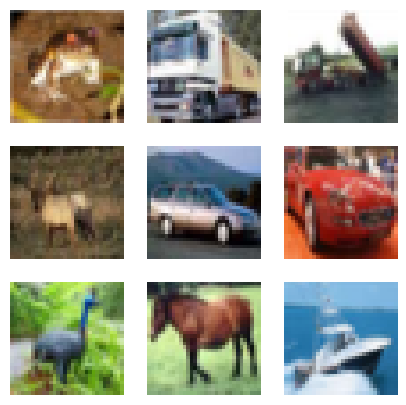

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()

To enhance model generalization and prevent overfitting, we'll increase dataset diversity through data augmentation.

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )
datagen.fit(X_train)

Here are some of the augmented images.

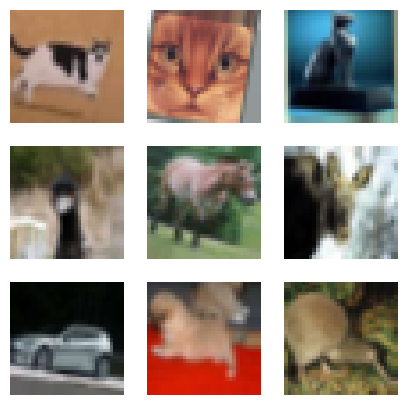

In [39]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
        plt.axis('off')
    plt.show()
    break

Since image channels have pixel values between 0 and 255, dividing by 255 rescales them to a more manageable 0-1 range, which is often preferred for machine learning models.

In [40]:
# Conver interger to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize data
X_train /= 255
X_test /= 255

Next, we will one-hot encode the output labels using `to_categorical` of the `tensorflow` library.

In [41]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

Finally, we will split the original training set into two a new training set and a validation set in a 4:1 ratio.

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

In [43]:
# Flatten the data
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Print the shapes
print(f'Shape of X_train: {X_train.shape}, shape of y_train: {y_train.shape}')
print(f'Shape of X_val:  {X_val.shape}, shape of y_val:  {y_val.shape}')
print(f'Shape of X_test:  {X_test.shape}, shape of y_test:  {y_test.shape}')

Shape of X_train: (40000, 3072), shape of y_train: (40000, 10)
Shape of X_val:  (10000, 3072), shape of y_val:  (10000, 10)
Shape of X_test:  (10000, 3072), shape of y_test:  (10000, 10)


## Save data

In [44]:
with open('../data/preprocessed_data.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_val, y_val, X_test, y_test), f)